In [1]:
import os
import sys
sys.path.append('../')
import numpy as np
import scipy.io as scio
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import numba
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tempfile import gettempdir
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2DC
from kwave.utils import *
from kwave.ktransducer import *
from kwave.kmedium import kWaveMedium

%matplotlib inline

### Load Initial Pressure

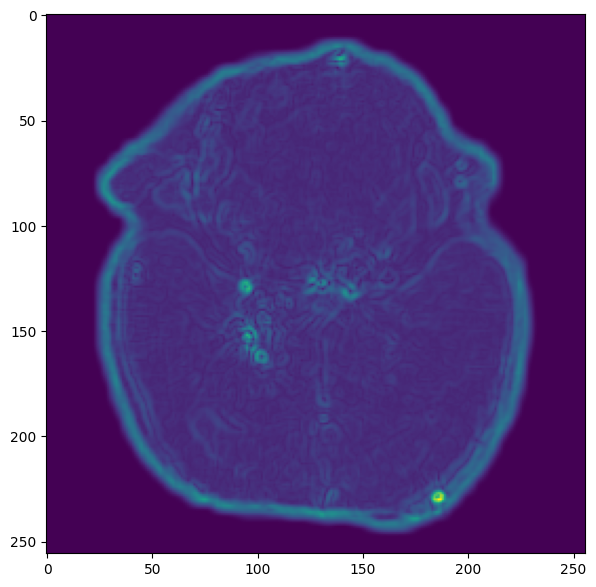

In [2]:
IP_img = np.load("data/brain/IP_brain.npy")
fig = plt.figure(figsize=(7,7))
plt.imshow(IP_img)

Subtract background and pad the image to the size of the computaional grid.

In [3]:
IP_img = (IP_img - IP_img.min()) / (IP_img.max() - IP_img.min()) # Background subtraction and normalization.
pad_x, pad_y = 2040, 2040 # 2024, 2024
IP_pad = np.zeros((pad_x, pad_y))
pad_start, pad_end = (pad_x-IP_img.shape[0])//2, (pad_x+IP_img.shape[1])//2
IP_pad[pad_start:pad_end, pad_start:pad_end] = IP_img
np.save('data/brain/IP_pad.npy', IP_pad)

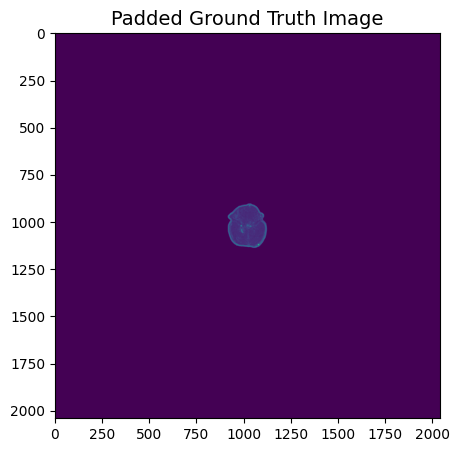

In [4]:
plt.figure(figsize=(5,5))
plt.title('Padded Ground Truth Image', fontsize=14)
plt.imshow(IP_pad)

In [5]:
pathname = gettempdir()

PML_size = 4# 12                               # Size of the PML in grid points.
Nx, Ny = IP_pad.shape
R_ring = 0.05                               # Radius of the ring array [m].
dx, dy = 5e-5, 5e-5 # 1.05*2*R_ring/Ny   # Grid point spacing in the y direction [m].
T_sample = 1/10e6                           # Sample time step [s].

N_transducer = 512                          # Number of transducers in ring array.
center_pos = [0, 0]
arc_angle = 2 * np.pi

kgrid = kWaveGrid([Nx, Ny], [dx, dy])
kgrid.dt = T_sample

In [6]:
kgrid.x_vec[1] - kgrid.x_vec[0]

array([5.e-05])

Define SoS distribution.

In [7]:
SoS_background = 1500.0         # SoS of the background medium. [m/s]
R, R1 = 0.006, 0.003            # Radius of circles in SoS distribution. [m]
offset = (0.0008 ,0.0006)       # Offset of circle in SoS distribution.[m]

XX, YY = np.meshgrid(kgrid.x_vec.copy(), kgrid.y_vec.copy())
SoS = np.ones((Ny, Nx)) * 1500
SoS[XX**2 + YY**2 < R**2] = 1600
SoS[(XX + offset[0])**2 + (YY + offset[1])**2 < R1**2] = 1650
SoS_das = 1512              # SoS used in DAS when medium is not uniform. [m/s]
rou = 1000  # Density.
medium = kWaveMedium(sound_speed=SoS, sound_speed_ref=SoS_background, density=rou)

Draw the SoS distribution and the size of image.

<Figure size 700x700 with 0 Axes>

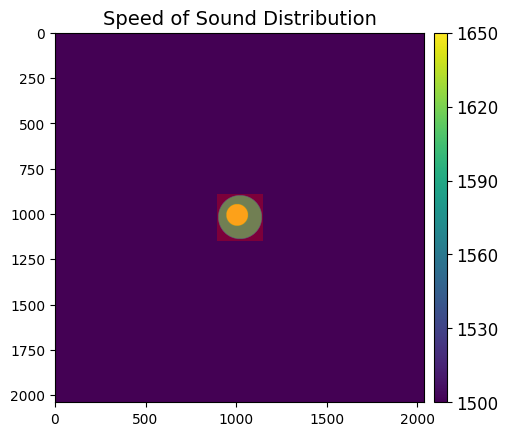

In [8]:
plt.figure(figsize=(7,7))
fig, ax = plt.subplots()
plt.title('Speed of Sound Distribution', fontsize=14)
plt.imshow(SoS)
left, bottom, width, height = (pad_x//2-128, pad_y//2-128, 256, 256)
image = mpatches.Rectangle((left,bottom), width, height, 
                           alpha=0.3,
                           facecolor="red")
plt.gca().add_patch(image) # Show the size of image.
cax = fig.add_axes([ax.get_position().x1+0.015, ax.get_position().y0, 0.02, ax.get_position().height])
cb = plt.colorbar(cax=cax)
cb.ax.tick_params(labelsize=13)
cb.ax.set_yticks([1500, 1530, 1560, 1590, 1620, 1650])
plt.tick_params(labelsize=12)
# plt.savefig('../figures/SoS.jpg', bbox_inches='tight')

### K-wave Forward Simulation

In [9]:
source = kSource()
source.p0 = IP_pad

# Smooth the initial pressure distribution and restore the magnitude.
# source.p0 = smooth(source.p0, True)

cart_sensor_mask = makeCartCircle(R_ring, N_transducer, center_pos, arc_angle)
sensor = kSensor(cart_sensor_mask) # Assign to sensor structure.

# Create the time array.
kgrid.makeTime(medium.sound_speed)

# Set the input arguements: force the PML to be outside the computational grid switch off p0 smoothing within kspaceFirstOrder2D.
input_args = {
    'PMLInside': False,
    'PMLSize': PML_size,
    'Smooth': False,
    'SaveToDisk': os.path.join(pathname, f'example_input.h5'),
    'SaveToDiskExit': False,
}

# Run the simulation.
sensor_data = kspaceFirstOrder2DC(**{
    'medium': medium,
    'kgrid': kgrid,
    'source': source,
    'sensor': sensor,
    **input_args
})

print(sensor_data.shape)

  start time: 29-Sep-2023-13-40-17
Running k-Wave simulation...
  start time: 29-Sep-2023-13-40-17
  reference sound speed:  1500.0 m/s
  reference sound speed:  1500.0 m/s
  dt:  9.0909ns , t_end: 96.1636us , time steps: 10579
  input grid size: 2040 by 2040 grid points (102.00000000000001 by 102.00000000000001 m)
  maximum supported frequency:  15.0M Hz
  expanding computational grid...
  computational grid size: 2048 by 2048 grid points
  precomputation completed in  0.2021233392879367 s
  saving input files to disk...
  completed in  1 min 22.80200472753495 s
┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                (512, 10579)


In [10]:
def reorder_binary_sensor_data(sensor_data, sensor, kgrid, PML_size):

    x_sensor = kgrid.x[sensor.mask[PML_size:-PML_size,PML_size:-PML_size] == 1]
    y_sensor = kgrid.y[sensor.mask[PML_size:-PML_size,PML_size:-PML_size] == 1]
    
    angle = np.arctan2(-x_sensor, -y_sensor)
    angle[angle < 0] = 2 * np.pi + angle[angle < 0]
    reorder_index = np.argsort(angle)
    
    return sensor_data[reorder_index]

sensor_data = reorder_binary_sensor_data(sensor_data, sensor, kgrid, PML_size)

In [11]:
def transducer_response(sensor_data, T_sample):

    return -2 * (sensor_data[:,1:] - sensor_data[:,:-1]) / T_sample

sensor_data = transducer_response(sensor_data, T_sample)

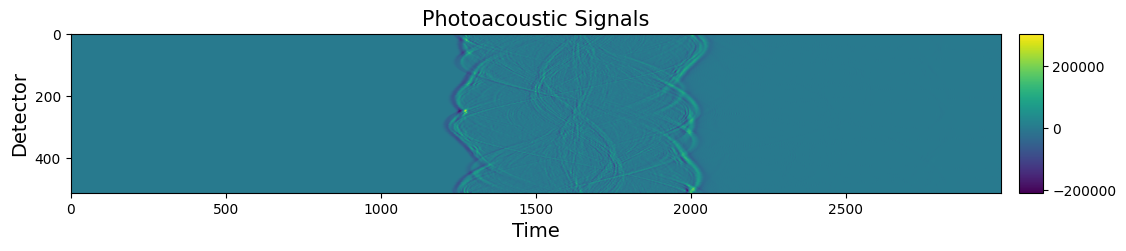

In [12]:
fig, ax = plt.subplots(figsize=(12,4))
plt.title('Photoacoustic Signals', fontsize=15)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Detector', fontsize=14)
plt.imshow(sensor_data[:,2000:5000])
cax = fig.add_axes([ax.get_position().x1+0.015, ax.get_position().y0, 0.02, ax.get_position().height])
plt.colorbar(cax=cax)
# plt.savefig('../figures/sensor_data.jpg', bbox_inches='tight')

### DAS Reconstruction

In [13]:
@numba.jit(nopython=True) 
def delay_and_sum(R_ring, T_sample, V_sound, Sinogram, ImageX, ImageY, d_delay=0):
    """Generate a 2D Delay And Sum reconstructed PACT image of ring transducer array. This function is accelerated by `numba.jit` on a GPU.

    Args:
        R_ring (`float`): The R_ring [m] of the ring transducer array.
        T_sample (`float`): Sample time interval [s] of the signals.
        V_sound (`float`): The sound speed [m/s] used for Delay And Sum reconstruction.
        Sinogram (`numpy.ndarray`): A 2D array and each column of it is the signal recievde by one transducer. The nummber of transducers should be the number of columns. The transducers should be evenly distributed on a circle in counterclockwise arrangement and the first column correspond to the transducer in the dirrection `2pi/N` in the first quartile. The first sample should be at time 0 when the photoacoustic effect happens.
        ImageX (`numpy.ndarray`): The vector [m] defining the x coordinates of the grid points on which the reconstruction is done. The values in the vector should be unifromly-spaced in ascending order. The origin of the cartesian coordinate system is the center of the ring array.
        ImageY (`numpy.ndarray`): The vector [m] defining the y coordinates of the grid points on which the reconstruction is done. The values in the vector should be unifromly-spaced in ascending order. The origin of the cartesian coordinate system is the center of the ring array.
        d_delay (`float`): The delay distance [m] of the signals used in DAS. The default value is 0.

    Returns:
        `numpy.ndarray`: A 2D array of size `(len(ImageY), len(ImageX))`. `Image[t, s]` is the reconstructed photoacoustic amplitude at the grid point `(ImageX[s], ImageY[t])`.
    """

    N_transducer = Sinogram.shape[0]
    Image = np.zeros((len(ImageX), len(ImageY)))
    delta_angle = 2*np.pi / N_transducer
    angle_transducer = delta_angle * (np.arange(N_transducer,) + 1)

    x_transducer = R_ring * np.sin(angle_transducer - np.pi)
    y_transducer = R_ring * np.cos(angle_transducer - np.pi)
    
    related_data = np.zeros((N_transducer,))
    
    for s in range(len(ImageX)):
        for t in range(len(ImageY)):
            distance_to_transducer = np.sqrt((x_transducer - ImageX[s])**2 + (y_transducer - ImageY[t])**2) - d_delay
            for k in range(N_transducer):
                id = floor(distance_to_transducer[k]/(V_sound * T_sample))
                if id > Sinogram.shape[1] or id < 0:
                    related_data[k] = 0
                else:
                    related_data[k] = Sinogram[k, id]
            Image[t, s] = related_data.mean()
    return Image

In [14]:
delay_step = 1e-4 # [m] (1e-5 in APACT)
n_delays = 8
d_delays = np.linspace(-(n_delays/2-1), n_delays/2, n_delays) * delay_step # + 6.8e-4
print(d_delays)
recons = []
for d_delay in d_delays:
    recon = delay_and_sum(R_ring,
                          kgrid.dt,
                          SoS_das,
                          sensor_data,
                          kgrid.x_vec[pad_start:pad_end],
                          kgrid.y_vec[pad_start:pad_end],
                          d_delay=d_delay)
    # recon *= IP_img.sum() / recon.sum()
    recons.append(recon)
obs_imgs = np.array(recons)

[-0.0003 -0.0002 -0.0001  0.      0.0001  0.0002  0.0003  0.0004]


Text(0.5, 1.0, 'Histogram of Ground Truth')

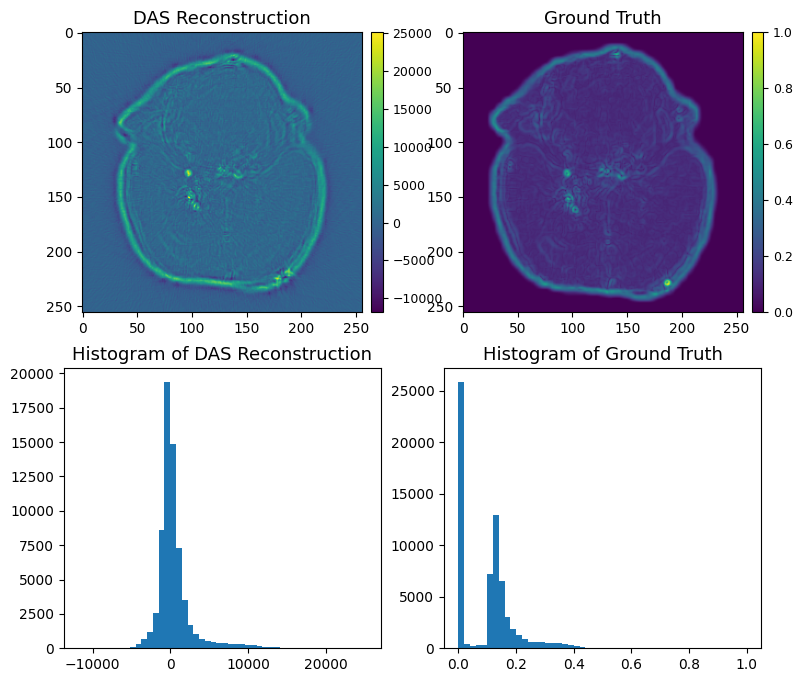

In [15]:
fig = plt.figure(figsize=(9,8))
vmax = np.max([recons[3].max(), IP_img.max()])
vmin = np.min([recons[3].min(), IP_img.min()])
norm = matplotlib.colors.Normalize(vmax=vmax, vmin=vmin)

ax1 = plt.subplot(2,2,1)
plt.imshow(recons[3])
plt.title('DAS Reconstruction', fontsize=13)
cax1 = fig.add_axes([ax1.get_position().x1+0.01, ax1.get_position().y0, 0.013, ax1.get_position().height])
cb1 = plt.colorbar(cax=cax1)
cb1.ax.tick_params(labelsize=9)
# cb1.ax.set_yticks([-0.2, -0.1, 0.0, 0.1])

plt.subplot(2,2,3)
plt.hist((recons[3]).ravel(), bins=50)
plt.title('Histogram of DAS Reconstruction', fontsize=13)
    
ax2 = plt.subplot(2,2,2)
plt.imshow(IP_img)
plt.title('Ground Truth', fontsize=13)
cax2 = fig.add_axes([ax2.get_position().x1+0.01, ax2.get_position().y0, 0.013, ax2.get_position().height])
cb2 = plt.colorbar(cax=cax2)
cb2.ax.tick_params(labelsize=9)


plt.subplot(2,2,4)
plt.hist(IP_img.ravel(), bins=50)
plt.title('Histogram of Ground Truth', fontsize=13)

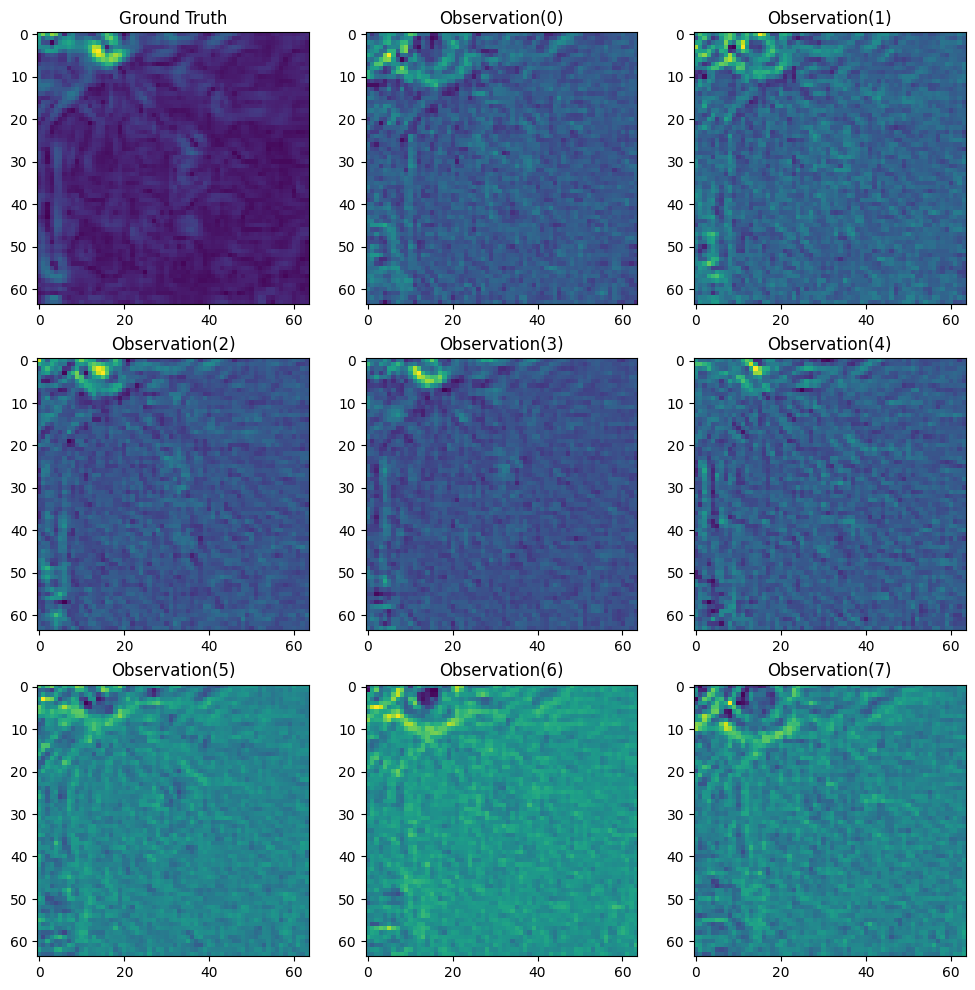

In [16]:
i, j = 4, 4
plt.figure(figsize=(12,12))
plt.subplot(3,3,1)
plt.imshow(IP_img[32*i:32*i+64, 32*j:32*j+64])
plt.title('Ground Truth')
for k in range(8):
    plt.subplot(3,3,k+2)
    plt.imshow(obs_imgs[k, 32*i:32*i+64, 32*j:32*j+64])
    plt.title(f'Observation({k})')

### Image with no SoS Distribution

In [17]:
SoS = np.ones((Ny, Nx)) * 1500
rou = 1000  # Density.
medium = kWaveMedium(sound_speed=SoS, sound_speed_ref=SoS_background, density=rou)

In [18]:
source = kSource()
source.p0 = IP_pad

# Smooth the initial pressure distribution and restore the magnitude.
# source.p0 = smooth(source.p0, True)

cart_sensor_mask = makeCartCircle(R_ring, N_transducer, center_pos, arc_angle)
sensor = kSensor(cart_sensor_mask) # Assign to sensor structure.

# Create the time array.
kgrid.makeTime(medium.sound_speed)

# Set the input arguements: force the PML to be outside the computational grid switch off p0 smoothing within kspaceFirstOrder2D.
input_args = {
    'PMLInside': False,
    'PMLSize': PML_size,
    'Smooth': False,
    'SaveToDisk': os.path.join(pathname, f'example_input.h5'),
    'SaveToDiskExit': False, 
}

# Run the simulation.
sensor_data_clean = kspaceFirstOrder2DC(**{
    'medium': medium,
    'kgrid': kgrid,
    'source': source,
    'sensor': sensor,
    # 'reorder_data': True,
    **input_args
})

  start time: 29-Sep-2023-13-43-32
Running k-Wave simulation...
  start time: 29-Sep-2023-13-43-32
  reference sound speed:  1500.0 m/s
  reference sound speed:  1500.0 m/s
  dt:  10.0ns , t_end: 96.16us , time steps: 9617
  input grid size: 2040 by 2040 grid points (102.00000000000001 by 102.00000000000001 m)
  maximum supported frequency:  15.0M Hz
  expanding computational grid...
  computational grid size: 2048 by 2048 grid points
  precomputation completed in  0.14900938607752323 s
  saving input files to disk...


  completed in  1 min 14.189841691404581 s


In [19]:
sensor_data_clean = reorder_binary_sensor_data(sensor_data_clean, sensor, kgrid, PML_size)
sensor_data_clean = transducer_response(sensor_data_clean, T_sample)

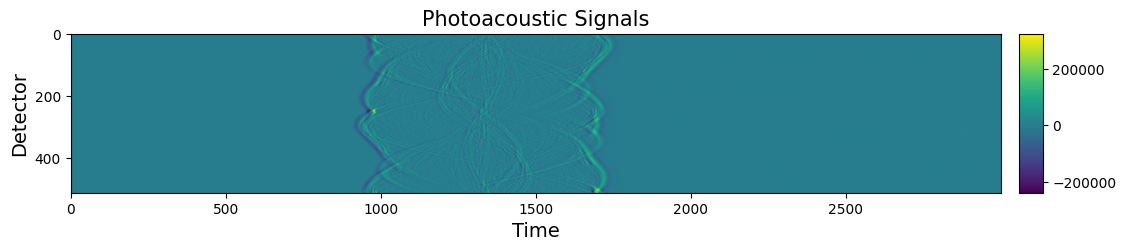

In [20]:
fig, ax = plt.subplots(figsize=(12,4))
plt.title('Photoacoustic Signals', fontsize=15)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Detector', fontsize=14)
plt.imshow(sensor_data_clean[:,2000:5000])
cax = fig.add_axes([ax.get_position().x1+0.015, ax.get_position().y0, 0.02, ax.get_position().height])
plt.colorbar(cax=cax)

In [21]:
recon_clean = delay_and_sum(R_ring,
                            kgrid.dt,
                            medium.sound_speed_ref,
                            sensor_data_clean,
                            kgrid.x_vec[pad_start:pad_end],
                            kgrid.y_vec[pad_start:pad_end],
                            d_delay=0)
recon_clean *= IP_img.sum()/ recon_clean.sum()

Text(0.5, 1.0, 'Histogram of Ground Truth')

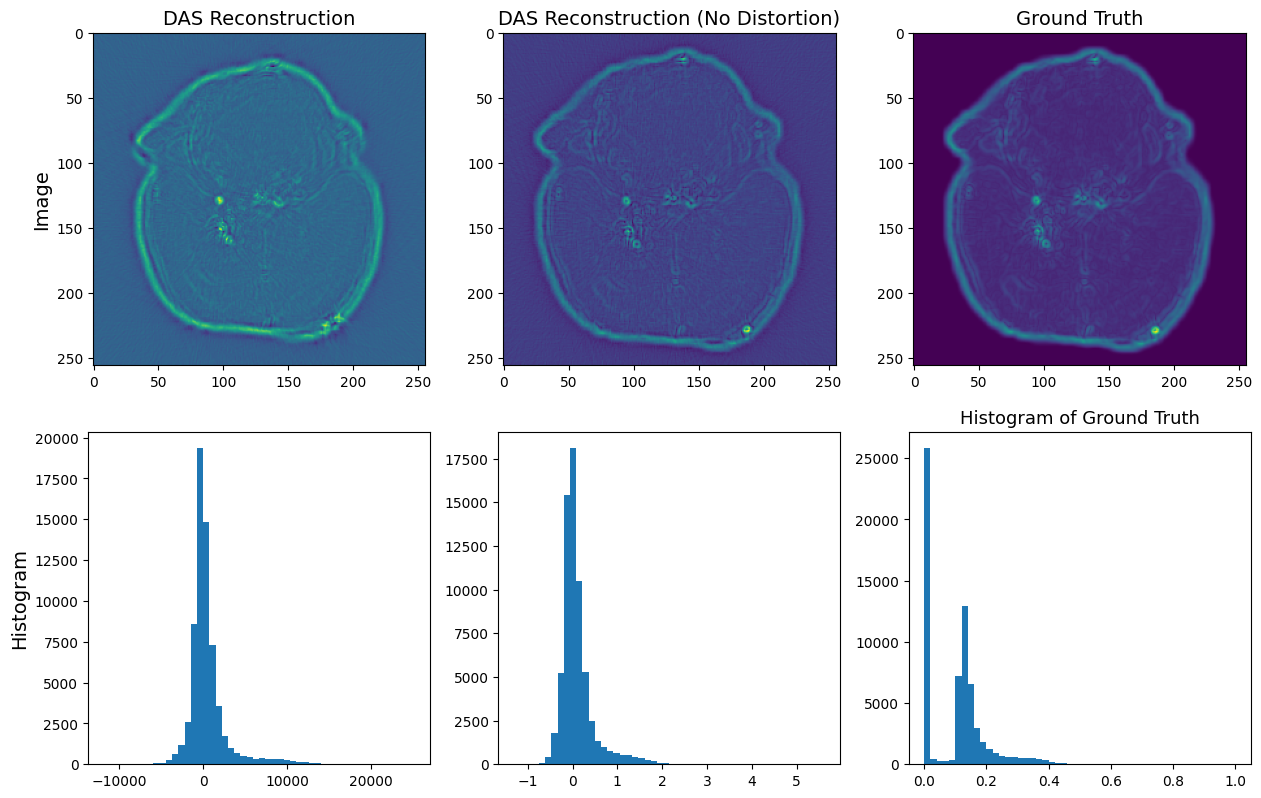

In [22]:
fig = plt.figure(figsize=(15,9.5))

ax1 = plt.subplot(2,3,1)
plt.imshow(recons[3])
plt.title('DAS Reconstruction', fontsize=14)
plt.ylabel('Image', fontsize=14)
# cax1 = fig.add_axes([ax1.get_position().x1+0.008, ax1.get_position().y0, 0.012, ax1.get_position().height])
# cb1 = plt.colorbar(cax=cax1)
# cb1.ax.tick_params(labelsize=9)
# cb1.ax.set_yticks([-0.2, -0.1, 0.0,/ 0.1])

plt.subplot(2,3,4)
plt.hist(recons[3].ravel(), bins=50)
# plt.title('Histogram of DAS Reconstruction', fontsize=13)
plt.ylabel('Histogram', fontsize=14)

ax2 = plt.subplot(2,3,2)
plt.imshow(recon_clean)
plt.title('DAS Reconstruction (No Distortion)', fontsize=14)
# cax2 = fig.add_axes([ax2.get_position().x1+0.008, ax2.get_position().y0, 0.012, ax2.get_position().height])
# cb2 = plt.colorbar(cax=cax2)
# cb2.ax.tick_params(labelsize=9)
# cb2.ax.set_yticks([-0.2, -0.1, 0.0, 0.1])

plt.subplot(2,3,5)
plt.hist(recon_clean.ravel(), bins=50)
# plt.title('Histogram of DAS Reconstruction', fontsize=13)

ax3 = plt.subplot(2,3,3)
plt.imshow(IP_img)
plt.title('Ground Truth', fontsize=14)
# cax3 = fig.add_axes([ax3.get_position().x1+0.008, ax3.get_position().y0, 0.012, ax3.get_position().height])
# cb3 = plt.colorbar(cax=cax3)
# cb3.ax.tick_params(labelsize=9)

plt.subplot(2,3,6)
plt.hist(IP_img.ravel(), bins=50)
plt.title('Histogram of Ground Truth', fontsize=13)

# plt.savefig('../figures/histogram.jpg', bbox_inches='tight')
# plt.imsave('../figures/gt.jpg', gt)
# plt.imsave('../figures/obs.jpg', recons[3])
# plt.imsave('../figures/rec.jpg', recon_clean)

Calculate PSF for each delay.

In [23]:
psfs = []
for recon in recons:
    psf = fftshift(ifft2(fft2(recon) / fft2(recon_clean))).real
    # psf = fftshift(ifft2(fft2(recon_clean) / fft2(gt))).real
    psfs.append(psf)

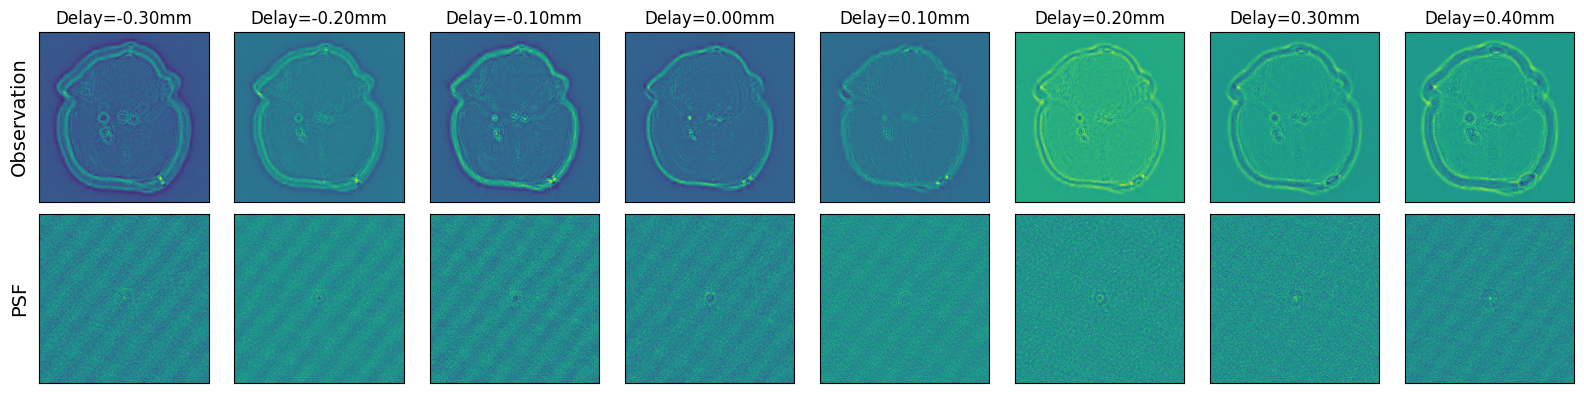

In [24]:
plt.figure(figsize=(16, 4))
for idx, d_delay in enumerate(d_delays):
    ax1 = plt.subplot(2,8,idx+1)
    plt.imshow(recons[idx])
    plt.title('Delay={:.2f}mm'.format(d_delay*1e3), fontsize=12)
    plt.xticks([])
    plt.yticks([])
    if idx == 0:
        plt.ylabel('Observation', fontsize=14)
    
    ax2 = plt.subplot(2,8,idx+9)
    plt.imshow(psfs[idx])
    plt.xticks([])
    plt.yticks([])
    if idx == 0:
        plt.ylabel('PSF', fontsize=14)

plt.tight_layout()
# plt.savefig('../figures/delays.jpg')

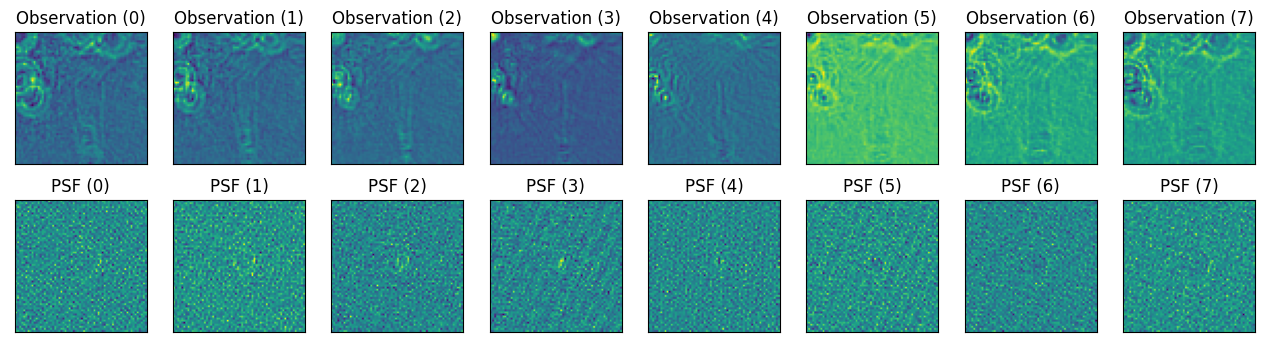

In [26]:
i, j = 4, 3
plt.figure(figsize=(16,4))
for k in range(8):
    size=64
    plt.subplot(2,8,k+1)
    plt.imshow(obs_imgs[k, 32*i:32*i+size, 32*j:32*j+size])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Observation ({k})')
    
    plt.subplot(2,8,k+9)
    psf = fftshift(ifft2(fft2(obs_imgs[k, 32*i:32*i+size, 32*j:32*j+size]) / fft2(recon_clean[32*i:32*i+size, 32*j:32*j+size]))).real
    plt.imshow(psf)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'PSF ({k})')